<a href="https://colab.research.google.com/github/lorenzobalzani/bayesian-network-credit-cards/blob/master/bayesian_network_credit_cards_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title: Bayesian Networks for measuring credit cards' default probabilities
## Course: Fundamentals of AI and KR % 3
### Authors: [**Lorenzo Balzani**](mailto:lorenzo.balzani@studio.unibo.it) and [**Thomas Guizzetti**](mailto:thomas.guizzetti@studio.unibo.it)

# Abstract
TODO

# Setup

## Requirements

In [1]:
!pip install -q pandas numpy pgmpy

     |████████████████████████████████| 1.9 MB 4.7 MB/s 


## Imports

In [2]:
import os, logging
import pandas as pd
import numpy as np

## Declarations

In [3]:
logger = logging.getLogger()
dataset_url = 'https://raw.githubusercontent.com/lorenzobalzani/bayesian-network-credit-cards/master/dataset.csv'

# Dataset

In [4]:
def read_dataset(url: str) -> pd.DataFrame:
  dataset = pd.read_csv(url, delimiter=';').set_index('ID') \
            .rename(columns={'default payment next month': 'default'})
  return dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
         .rename(columns={column: column.lower() for column in dataset.columns})

dataset = read_dataset(dataset_url)

## Distribution of `limit_bal` 
First, we print out the histogram related to the distribution of `limit_bal`, which is the only continuous variable used.

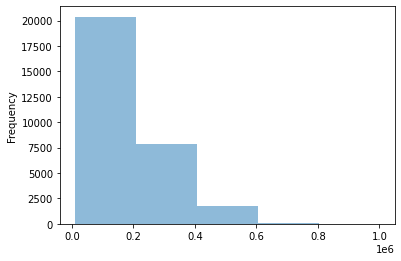

In [5]:
ax = dataset['limit_bal'].plot.hist(bins=5, alpha=0.5)

Next, we describe the distribution. To discretize it, we would like to create four beams (i.e., corresponding to the four percentiles).

In [6]:
dataset['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

## Manipulation
The *artificial column* `misspayments_prev_6_months` can hold either positive, negative numbers or 0. In particular, this means: 
1. $ n = -2 $ corresponds to there was no credit to pay;
2. $ n = -1 $ corresponds to payed successfully;
3. $ n = 0 $ corresponds to a payment that was made on time but not totally to clear the balance (i.e., the minimum payment was met);
4. $ n > 0 $ corresponds to the number of delayed months.

All computations - but `misspayments_prev_6_months` - are performed in a vectorized fashion using NumPy. The less efficient alternative would have used the `apply` method over Pandas DataFrame, which internally leverages a for loop.

In [7]:
%%time

def manipulate_dataset(df: pd.DataFrame) -> pd.DataFrame:
  compute_misspayments = lambda payments_status: sum([payment_status > 0 for payment_status in payments_status])
  df['sex'] = np.where(df['sex'] == 1, 'male', 'female')
  df['marriage'] = np.where(df['marriage'] == 1, 'married', 'not_married')
  df['age'] = np.select([
              (df['age'] < 35), 
              (df['age'] >= 35) & (df['age'] < 60)],
              ['young', 'mid_aged'], default = 'senior')
  df['limit_bal'] = np.select([
                    (df['limit_bal'] < 50_000), 
                    (df['limit_bal'] >= 50_000) & (df['limit_bal'] < 140_000),
                    (df['limit_bal'] >= 140_000) & (df['limit_bal'] < 240_000)],
                    ['low', 'medium', 'medium_high'], default = 'high')
  df['education'] = np.select([
                    (df['education'] == 1), 
                    (df['education'] == 2), 
                    (df['education'] == 3)], 
                    ['graduate', 'university', 'high_school'], default = 'others') 
  df['misspayments_prev_6_months'] = df.apply(lambda row: \
                                              compute_misspayments([row[column] for column in df.columns if 'pay_' in column]), 
                                              axis=1) #axis = 1 means row by row
  return df.drop(columns=[column for column in df.columns if 'pay_' in column])

dataset = manipulate_dataset(read_dataset(dataset_url))

CPU times: user 1.23 s, sys: 29.9 ms, total: 1.26 s
Wall time: 1.37 s


## Final dataset

In [8]:
dataset.head()

,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
ID,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0
